In [225]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import datetime
import os
import csv
import io
import random
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure
from sklearn.metrics import mean_absolute_error as mae

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [226]:
num_lags = 3
timesteps = 30
setting = 'FNN_daily_R3_30'
title = 'FNN (ReLU, 3 Hidden Layers) Model Performance for Daily Data: 30 Time Steps'

In [227]:
# read in data
df = pd.read_csv('j17_daily.csv')
pd.DataFrame.reset_index(df, drop=True)
del df['Site']
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores["DailyHighDate"] = df['DailyHighDate']
z_scores['WaterLevelElevation'] = df['WaterLevelElevation']
z_scores['Z Scores'], mean, std = z_score_calc(df,'WaterLevelElevation') # noramlization speeds up learning and leads to faster convergence
z_scores.to_csv("j17wl_daily_z_scores.csv") 
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
cols = []
for i in range(num_lags):
    cols.append(i+1)
# prepare data
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
#ds_x = np.flip(ds_x,axis=0)
#ds_y = np.flip(ds_y,axis=0)
print(ds_x)
print(ds_y)
# ~80% training
ds_train_x = ds_x[:int(0.8*len(ds_x))]
ds_train_y = ds_y[:int(0.8*len(ds_x))]
# ~20% testing
ds_test_x = ds_x[int(0.8*len(ds_x)):]
ds_test_y = ds_y[int(0.8*len(ds_x)):]

[[0.14865702 0.20097308 0.23359369]
 [0.06679777 0.14865702 0.20097308]
 [0.07233712 0.06679777 0.14865702]
 ...
 [0.67489506 0.67181764 0.66073895]
 [0.66566281 0.67489506 0.67181764]
 [0.65212218 0.66566281 0.67489506]]
[-0.23601991 -0.25140698 -0.23725087 ...  0.67120216  0.66935571
  0.66504733]


In [228]:
# build NN
epochs = 50
batch_size = 100
model = keras.Sequential()
model.add(keras.layers.Dense(10, activation='relu', input_dim=num_lags))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(10))
model.add(keras.layers.Dense(1)) # output layer; gives a 1D output
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(ds_train_x, ds_train_y, batch_size=batch_size, epochs=epochs, verbose=3)
# apply to predictions
predictions = model.predict(ds_test_x)
r = []
for i in predictions:
    r.append(i[0])
result = np.array(r)
predicted_vals = result * std + mean
true_vals = ds_test_y * std + mean
diff = true_vals - predicted_vals
corr_m = np.corrcoef(predicted_vals, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")
mse = np.square(diff).mean()
print('MSE = ' + str(mse))
mae = np.mean(np.abs(diff))
print('MAE = ' + str(mae))

Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50
R2 = 91.1154262674807%
MSE = 7.3875760923151015
MAE = 1.8759911017941007


In [229]:
#plt.plot(history.history['mean_absolute_error'])

In [230]:
tf.keras.models.save_model(model,'Saved Models/'+setting)

INFO:tensorflow:Assets written to: Saved Models/FNN_daily_R3_30/assets


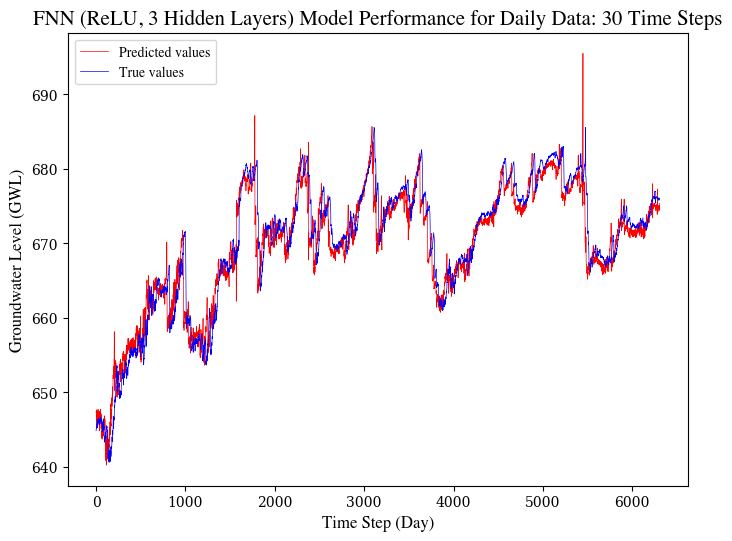

In [231]:
plt.rcParams['font.family'] = 'serif'
f='Times'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_serif.png', dpi=300)
plt.show()

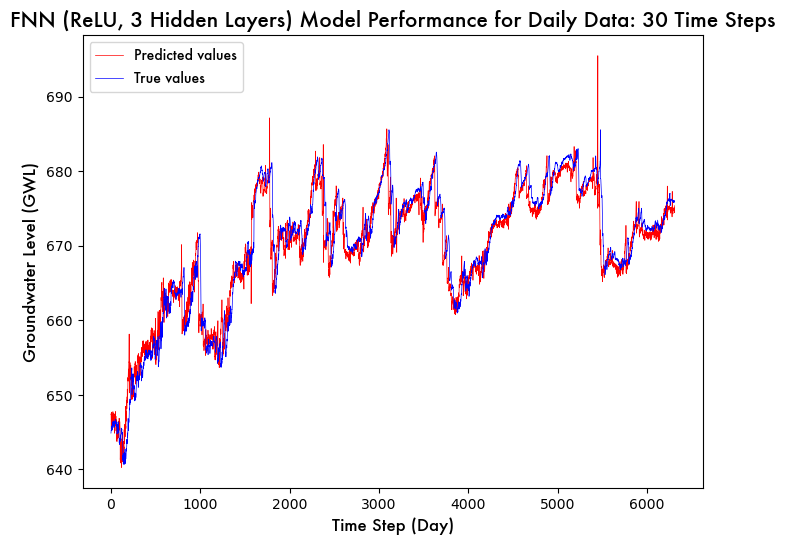

In [232]:
plt.rcParams['font.family'] = 'sans-serif'
f='Futura'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_sans-serif.png', dpi=300)
plt.show()

In [233]:
print('R2 = ' + str(r2*100) + "%")
print('MSE = ' + str(mse))
print('MAE = ' + str(mae))

R2 = 91.1154262674807%
MSE = 7.3875760923151015
MAE = 1.8759911017941007
